In [1]:
# try these chemprop params (Gerard):
# (hidden_size=300, depth=3, dropout=0.05, ffn_num_layers=300, activation=ReLU, bias=False, max_lr=1e-3, epochs=50)

# protein descriptors - not relevant / chemprop (poss. discussion)

# visualiseer polypharmacology in dataset
# al gevonden polypharmacology
# waar voorspelt mijn model polypharmacology

In [2]:
# load packages

import os
import pandas as pd
from qsprpred.data import QSPRDataset
from sklearn.impute import SimpleImputer
from qsprpred.data import QSPRDataset, RandomSplit
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.data.descriptors.sets import SmilesDesc
from qsprpred.data.sampling.splits import GBMTRandomSplit, GBMTDataSplit, ManualSplit
from split import random_global_equilibrated_random_split, dissimilaritydrive_global_balanced_cluster_split
from qsprpred.extra.gpu.models.chemprop import ChempropModel
from qsprpred.models import CrossValAssessor, TestSetAssessor
from qsprpred.models.early_stopping import EarlyStoppingMode
# from qsprpred.plotting.regression import CorrelationPlot
from plotting_regression_MT import CorrelationPlot

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
df=pd.read_csv('/home/s2861704/ppk/test_kin/output/TK/TK_split.csv', sep=',')
display(df)
print(df.columns)

,SMILES,O60674,P00519,P00533,P04626,P04629,P06213,P06239,P07333,P07949,...,Q06187,Q06418,Q07912,Q08345,Q08881,Q12866,Q16288,Q16620,Q16832,split
0,BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,Brc1cc2c(NCc3ccccc3)ncnc2s1,NaN,NaN,6.62,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36999,c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
37000,c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
37001,c1ncc(-c2cc(CNc3nc(Nc4cc(C5CC5)[nH]n4)cc(N4CCO...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
37002,c1ncc(CN2CCC(n3cnc4cnc5[nH]ccc5c43)CC2)cn1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


Index(['SMILES', 'O60674', 'P00519', 'P00533', 'P04626', 'P04629', 'P06213',
       'P06239', 'P07333', 'P07949', 'P08069', 'P08581', 'P09581', 'P09619',
       'P10721', 'P11362', 'P12931', 'P16234', 'P17948', 'P21802', 'P22455',
       'P22607', 'P23458', 'P29317', 'P29597', 'P30530', 'P35968', 'P36888',
       'P43405', 'P52333', 'P54760', 'Q02763', 'Q05397', 'Q06187', 'Q06418',
       'Q07912', 'Q08345', 'Q08881', 'Q12866', 'Q16288', 'Q16620', 'Q16832',
       'split'],
      dtype='object')


In [4]:
targets_kinase200 = df.columns[1:42].tolist()
display(targets_kinase200)

['O60674',
 'P00519',
 'P00533',
 'P04626',
 'P04629',
 'P06213',
 'P06239',
 'P07333',
 'P07949',
 'P08069',
 'P08581',
 'P09581',
 'P09619',
 'P10721',
 'P11362',
 'P12931',
 'P16234',
 'P17948',
 'P21802',
 'P22455',
 'P22607',
 'P23458',
 'P29317',
 'P29597',
 'P30530',
 'P35968',
 'P36888',
 'P43405',
 'P52333',
 'P54760',
 'Q02763',
 'Q05397',
 'Q06187',
 'Q06418',
 'Q07912',
 'Q08345',
 'Q08881',
 'Q12866',
 'Q16288',
 'Q16620',
 'Q16832']

O60674
                                                  SMILES  O60674  split
0                   BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1     NaN  train
1                  BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1     NaN  train
2                BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1     NaN  train
3          Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1     NaN  train
4                            Brc1cc2c(NCc3ccccc3)ncnc2s1     NaN  train
...                                                  ...     ...    ...
36999  c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...     NaN  train
37000  c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...     NaN  train
37001  c1ncc(-c2cc(CNc3nc(Nc4cc(C5CC5)[nH]n4)cc(N4CCO...     NaN  train
37002         c1ncc(CN2CCC(n3cnc4cnc5[nH]ccc5c43)CC2)cn1     NaN  train
37003                            c1nnc2nnc(N3CCOCC3)nn12     NaN  train

[37004 rows x 3 columns]
                                                  SMILES     O60674  split
221    C#CCN1CCc2cc(Nc3ncc(C

/home/s2861704/.conda/envs/drugex_env/lib/python3.12/site-packages/qsprpred/data/tables/pandas.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[name] = generate_padded_index(self.df.index, prefix=prefix)
/home/s2861704/.conda/envs/drugex_env/lib/python3.12/site-packages/qsprpred/data/tables/pandas.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.idProp] = self.df[self.indexCols].apply(
/home/s2861704/.conda/envs/drugex_env/lib/python3.12/site-packages/qsprpred/data/tables/pand

ChempropSTModel_RGES
                     Model                       QSPRID              Fold  \
0     ChempropSTModel_RGES  ChempropSTDataset_RGES_0000               3.0   
1     ChempropSTModel_RGES  ChempropSTDataset_RGES_0002               4.0   
2     ChempropSTModel_RGES  ChempropSTDataset_RGES_0003               2.0   
3     ChempropSTModel_RGES  ChempropSTDataset_RGES_0005               3.0   
4     ChempropSTModel_RGES  ChempropSTDataset_RGES_0006               4.0   
...                    ...                          ...               ...   
3156  ChempropSTModel_RGES  ChempropSTDataset_RGES_3151  Independent Test   
3157  ChempropSTModel_RGES  ChempropSTDataset_RGES_3152  Independent Test   
3158  ChempropSTModel_RGES  ChempropSTDataset_RGES_3154  Independent Test   
3159  ChempropSTModel_RGES  ChempropSTDataset_RGES_3155  Independent Test   
3160  ChempropSTModel_RGES  ChempropSTDataset_RGES_3158  Independent Test   

     Property  Label  Prediction               Set  
0

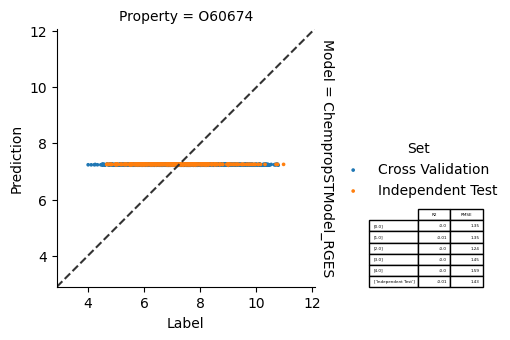

P00519
                                                  SMILES  P00519  split
0                   BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1     NaN  train
1                  BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1     NaN  train
2                BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1     NaN  train
3          Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1     NaN  train
4                            Brc1cc2c(NCc3ccccc3)ncnc2s1     NaN  train
...                                                  ...     ...    ...
36999  c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...     NaN  train
37000  c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...     NaN  train
37001  c1ncc(-c2cc(CNc3nc(Nc4cc(C5CC5)[nH]n4)cc(N4CCO...     NaN  train
37002         c1ncc(CN2CCC(n3cnc4cnc5[nH]ccc5c43)CC2)cn1     NaN  train
37003                            c1nnc2nnc(N3CCOCC3)nn12     NaN  train

[37004 rows x 3 columns]
                                                  SMILES   P00519  split
228    C#CCOC1C(C)C(COC(=O)c2c

/home/s2861704/.conda/envs/drugex_env/lib/python3.12/site-packages/qsprpred/data/tables/pandas.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[name] = generate_padded_index(self.df.index, prefix=prefix)
/home/s2861704/.conda/envs/drugex_env/lib/python3.12/site-packages/qsprpred/data/tables/pandas.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.idProp] = self.df[self.indexCols].apply(
/home/s2861704/.conda/envs/drugex_env/lib/python3.12/site-packages/qsprpred/data/tables/pand

ChempropSTModel_RGES
                     Model                       QSPRID              Fold  \
0     ChempropSTModel_RGES  ChempropSTDataset_RGES_0000               2.0   
1     ChempropSTModel_RGES  ChempropSTDataset_RGES_0001               4.0   
2     ChempropSTModel_RGES  ChempropSTDataset_RGES_0004               0.0   
3     ChempropSTModel_RGES  ChempropSTDataset_RGES_0005               2.0   
4     ChempropSTModel_RGES  ChempropSTDataset_RGES_0006               4.0   
...                    ...                          ...               ...   
1157  ChempropSTModel_RGES  ChempropSTDataset_RGES_1149  Independent Test   
1158  ChempropSTModel_RGES  ChempropSTDataset_RGES_1151  Independent Test   
1159  ChempropSTModel_RGES  ChempropSTDataset_RGES_1153  Independent Test   
1160  ChempropSTModel_RGES  ChempropSTDataset_RGES_1159  Independent Test   
1161  ChempropSTModel_RGES  ChempropSTDataset_RGES_1161  Independent Test   

     Property  Label  Prediction               Set  
0

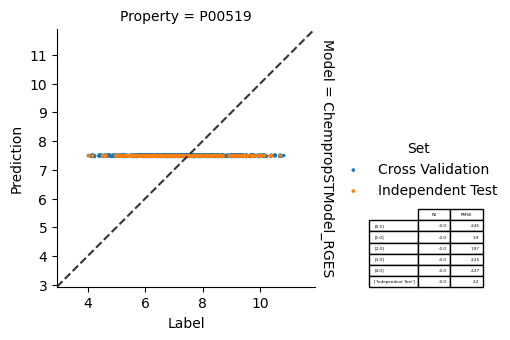

P00533
                                                  SMILES  P00533  split
0                   BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1     NaN  train
1                  BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1     NaN  train
2                BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1     NaN  train
3          Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1     NaN  train
4                            Brc1cc2c(NCc3ccccc3)ncnc2s1    6.62  train
...                                                  ...     ...    ...
36999  c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...     NaN  train
37000  c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...     NaN  train
37001  c1ncc(-c2cc(CNc3nc(Nc4cc(C5CC5)[nH]n4)cc(N4CCO...     NaN  train
37002         c1ncc(CN2CCC(n3cnc4cnc5[nH]ccc5c43)CC2)cn1     NaN  train
37003                            c1nnc2nnc(N3CCOCC3)nn12     NaN  train

[37004 rows x 3 columns]
                                                  SMILES  P00533  split
4                            Br

/home/s2861704/.conda/envs/drugex_env/lib/python3.12/site-packages/qsprpred/data/tables/pandas.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[name] = generate_padded_index(self.df.index, prefix=prefix)
/home/s2861704/.conda/envs/drugex_env/lib/python3.12/site-packages/qsprpred/data/tables/pandas.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.idProp] = self.df[self.indexCols].apply(
/home/s2861704/.conda/envs/drugex_env/lib/python3.12/site-packages/qsprpred/data/tables/pand

In [ ]:
for target in targets_kinase200:
    print(target)
    df_st = df[["SMILES", target, "split"]]
    print(df_st)
    df_st_nonan = df_st.dropna(axis=0)
    
    print(df_st_nonan)

    # Create dataset
    dataset = QSPRDataset(
        df=df_st_nonan,
        store_dir="/home/s2861704/ppk/test_kin/output/RGES/data",
        name="ChempropSTDataset_RGES",
        target_props=[{"name": target, "task": "REGRESSION"}],
        random_state=42,
        overwrite=True,
    )
    dataset.getDF()

    # calculate compound features and split dataset into train and test
    feature_calculators = [SmilesDesc(), MorganFP(radius=3, nBits=2048)]
    dataset.prepareDataset(
        split=ManualSplit(splitcol=dataset.df["split"], trainval="train", testval="test"), #luukkonen rges split implement
        feature_calculators=feature_calculators,
        recalculate_features=True,
    )

    # create model
    ChempropModel.getAvailableParameters()
    os.makedirs("/home/s2861704/ppk/test_kin/output/RGES/models", exist_ok=True)
    model = ChempropModel(
        base_dir='/home/s2861704/ppk/test_kin/output/RGES/models',
        name='ChempropSTModel_RGES',
        parameters={"epochs": 5},
        quiet_logger=False
    )

    # assess model performance
    CrossValAssessor('r2')(model, dataset)
    TestSetAssessor('r2')(model, dataset)
    model.earlyStopping.numEpochs = 25
    model.fitDataset(dataset, mode=EarlyStoppingMode.FIXED)
    _ = model.save()

    # plot results
    path = '/home/s2861704/ppk/test_kin/output/RGES/'
    fullname = os.path.join(path, target)
    outdir = fullname + '.png'
    
    plot = CorrelationPlot([model])
    axes, summary = plot.make(save=True, show=True, out_path=outdir)